Day 11 - Making a new simulation model (CIR) : Cox-Ingersoll-Ross, used for interest rates / volatility. Difference with the models before (OU/GBM) = process stays non negative (there is a squared term in the formula that makes it happen)

Day 12 - Same but with milstein model, we'll get a better strong convergence rate than EM !

Feller condition check: 2*theta*kappa - sigma^2 = 0.0575
Feller condition satisfied (process should stay positive).

Running CIR simulation...
Simulation finished in 0.01s


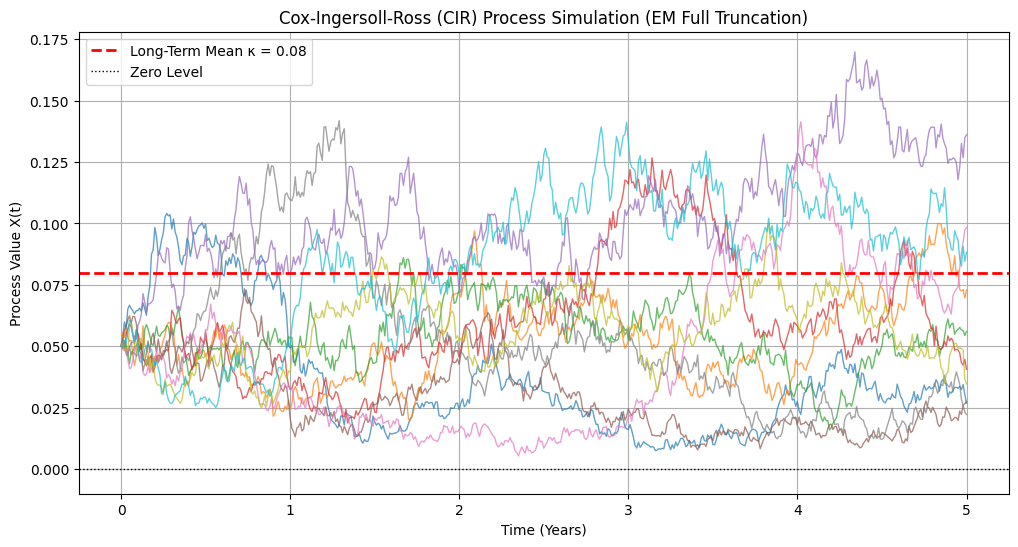


Minimum value reached across all paths: 0.005340

--- Simulating CIR Paths using Milstein Scheme ---


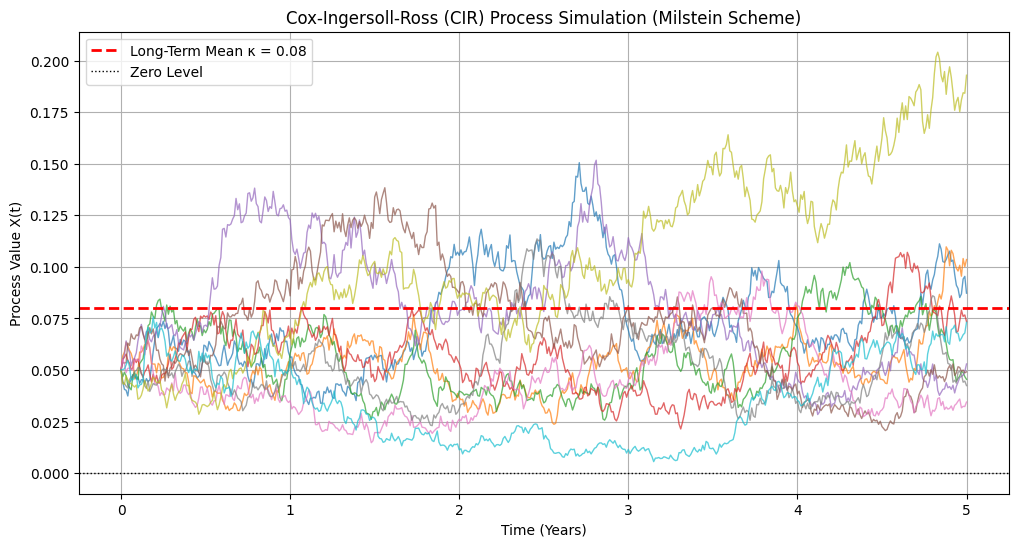

Minimum value reached across Milstein paths: 0.005554

--- Starting Strong Convergence Analysis for CIR (EM vs Milstein) ---
Using 2000 paths.
Running CIR Conv. Check: Coarse dt=0.62500, Fine dt=0.15625
Running CIR Conv. Check: Coarse dt=0.31250, Fine dt=0.07812
Running CIR Conv. Check: Coarse dt=0.15625, Fine dt=0.03906
Running CIR Conv. Check: Coarse dt=0.07812, Fine dt=0.01953
Running CIR Conv. Check: Coarse dt=0.03906, Fine dt=0.00977


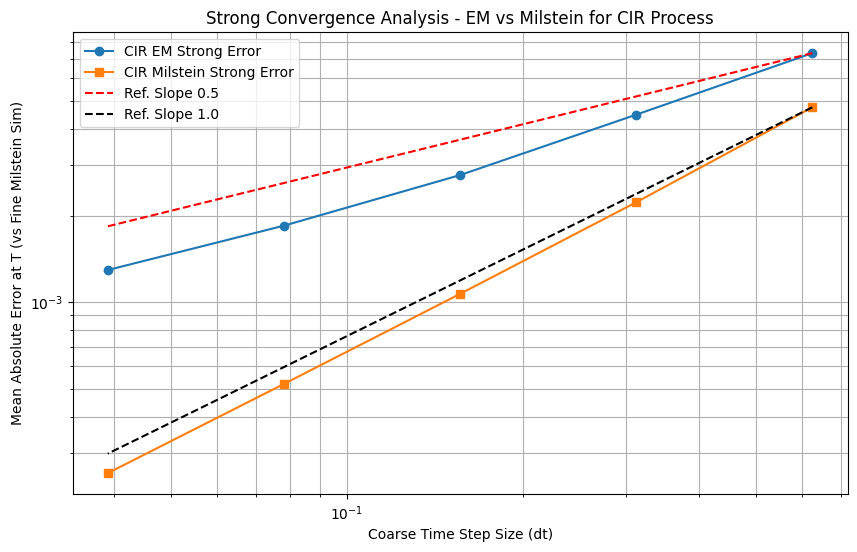

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time 

notebook_dir = os.path.dirname(os.path.abspath("__file__")) 
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from sde_simulator.simulators import simulate_cir_em_vectorized, simulate_cir_milstein_vectorized 

#choose parameters that satisfy Feller condition: 2*theta*kappa >= sigma^2
X0_CIR = 0.05      #initial value (e.g., 5% interest rate)
THETA_CIR = 0.5    #speed of reversion
KAPPA_CIR = 0.08   #long-term mean (e.g., 8%)
SIGMA_CIR = 0.15   #volatility parameter
T_CIR = 5.0        #time horizon (5 years)
DT_CIR = 0.01      #time step
NUM_PATHS_CIR = 10 #number of paths for visualization (less is more visible, so 10 here)

#check Feller condition
feller_cond = 2 * THETA_CIR * KAPPA_CIR - SIGMA_CIR**2
print(f"Feller condition check: 2*theta*kappa - sigma^2 = {feller_cond:.4f}")
if feller_cond >= 0:
    print("Feller condition satisfied (process should stay positive).")
else:
    print("Warning: Feller condition NOT satisfied (process might hit zero).")

print("\nRunning CIR simulation...")
start_time = time.time()
t_cir, X_cir_paths = simulate_cir_em_vectorized(
    X0_CIR, THETA_CIR, KAPPA_CIR, SIGMA_CIR, 
    T_CIR, DT_CIR, NUM_PATHS_CIR
)
end_time = time.time()
print(f"Simulation finished in {end_time - start_time:.2f}s")

plt.figure(figsize=(12, 6))
plt.plot(t_cir, X_cir_paths[:, :NUM_PATHS_CIR], lw=1, alpha=0.7)
#highlight the mean level kappa
plt.axhline(KAPPA_CIR, color='red', linestyle='--', lw=2, label=f'Long-Term Mean κ = {KAPPA_CIR}')
#highlight zero level
plt.axhline(0, color='black', linestyle=':', lw=1, label='Zero Level')
plt.title(f'Cox-Ingersoll-Ross (CIR) Process Simulation (EM Full Truncation)')
plt.xlabel('Time (Years)')
plt.ylabel('Process Value X(t)')
plt.ylim(bottom=-0.01) #start y-axis slightly below zero to check positivity clearly
plt.legend()
plt.grid(True)
plt.show()

#print min value reached to check positivity
print(f"\nMinimum value reached across all paths: {np.min(X_cir_paths):.6f}")





#use parameters for visualization
DT_VIS = 0.01
NUM_PATHS_VIS = 10

print(f"\n--- Simulating CIR Paths using Milstein Scheme ---")

#run Milstein simulation
t_cir_milstein, X_cir_milstein_paths = simulate_cir_milstein_vectorized(
    X0_CIR, THETA_CIR, KAPPA_CIR, SIGMA_CIR, 
    T_CIR, DT_VIS, NUM_PATHS_VIS 
    #note: not passing Z, so it uses fresh random numbers
)

#plot Milstein paths
plt.figure(figsize=(12, 6))
plt.plot(t_cir_milstein, X_cir_milstein_paths[:, :NUM_PATHS_VIS], lw=1, alpha=0.7)

#highlight the mean level kappa
plt.axhline(KAPPA_CIR, color='red', linestyle='--', lw=2, label=f'Long-Term Mean κ = {KAPPA_CIR}')
#highlight zero level
plt.axhline(0, color='black', linestyle=':', lw=1, label='Zero Level')

plt.title(f'Cox-Ingersoll-Ross (CIR) Process Simulation (Milstein Scheme)')
plt.xlabel('Time (Years)')
plt.ylabel('Process Value X(t)')
plt.ylim(bottom=-0.01) #start y-axis slightly below zero to check positivity clearly
plt.legend()
plt.grid(True)
plt.show()

#print min value reached to check positivity
print(f"Minimum value reached across Milstein paths: {np.min(X_cir_milstein_paths):.6f}")






#use a reasonable number of paths
NUM_PATHS_CONV_CIR = 2000 #adjust if needed for speed/accuracy

print(f"\n--- Starting Strong Convergence Analysis for CIR (EM vs Milstein) ---")
print(f"Using {NUM_PATHS_CONV_CIR} paths.")

#refinement factor
M = 4 

#range of COARSE steps
n_steps_coarse_range = 2**np.arange(3, 8) #8, 16, 32, 64, 128

dt_values_cir = np.zeros(len(n_steps_coarse_range))
strong_errors_cir_em = np.zeros(len(n_steps_coarse_range))
strong_errors_cir_milstein = np.zeros(len(n_steps_coarse_range))

#loop through different numbers of coarse steps
for i, n_steps_coarse in enumerate(n_steps_coarse_range):
    dt_coarse = T_CIR / n_steps_coarse
    dt_values_cir[i] = dt_coarse
    
    n_steps_fine = n_steps_coarse * M
    dt_fine = T_CIR / n_steps_fine
    
    print(f"Running CIR Conv. Check: Coarse dt={dt_coarse:.5f}, Fine dt={dt_fine:.5f}")

    #1. generate fine-grained random numbers
    Z_fine = np.random.normal(0, 1, size=(n_steps_fine, NUM_PATHS_CONV_CIR))

    #2. simulate reference solution with MILSTEIN and fine steps
    _, X_fine_ref = simulate_cir_milstein_vectorized(
        X0_CIR, THETA_CIR, KAPPA_CIR, SIGMA_CIR, T_CIR, dt_fine, NUM_PATHS_CONV_CIR, Z=Z_fine
    )
    X_T_ref = X_fine_ref[-1, :]

    #3. aggregate random numbers for coarse steps
    Z_fine_reshaped = Z_fine.reshape(n_steps_coarse, M, NUM_PATHS_CONV_CIR)
    Z_coarse = np.sum(Z_fine_reshaped, axis=1) / np.sqrt(M) 
    
    #4a. simulate coarse EM solution using aggregated random numbers
    _, X_coarse_em = simulate_cir_em_vectorized(
        X0_CIR, THETA_CIR, KAPPA_CIR, SIGMA_CIR, T_CIR, dt_coarse, NUM_PATHS_CONV_CIR, Z=Z_coarse
    )
    X_T_sim_em = X_coarse_em[-1, :]
    
    #4b. simulate coarse Milstein solution using aggregated random numbers
    _, X_coarse_milstein = simulate_cir_milstein_vectorized(
        X0_CIR, THETA_CIR, KAPPA_CIR, SIGMA_CIR, T_CIR, dt_coarse, NUM_PATHS_CONV_CIR, Z=Z_coarse
    )
    X_T_sim_milstein = X_coarse_milstein[-1, :]

    #5. calculate the mean absolute errors vs reference
    strong_errors_cir_em[i] = np.mean(np.abs(X_T_sim_em - X_T_ref))
    strong_errors_cir_milstein[i] = np.mean(np.abs(X_T_sim_milstein - X_T_ref))

plt.figure(figsize=(10, 6))
plt.plot(dt_values_cir, strong_errors_cir_em, 'o-', label='CIR EM Strong Error')
plt.plot(dt_values_cir, strong_errors_cir_milstein, 's-', label='CIR Milstein Strong Error')


#add reference line for slope 0.5 (scaled to EM error)
plt.plot(dt_values_cir, strong_errors_cir_em[0] * (dt_values_cir / dt_values_cir[0])**0.5,
         'r--', label='Ref. Slope 0.5')
         
#add reference line for slope 1.0 (scaled to Milstein error)
plt.plot(dt_values_cir, strong_errors_cir_milstein[0] * (dt_values_cir / dt_values_cir[0])**1.0,
         'k--', label='Ref. Slope 1.0')

plt.title('Strong Convergence Analysis - EM vs Milstein for CIR Process')
plt.xlabel('Coarse Time Step Size (dt)')
plt.ylabel('Mean Absolute Error at T (vs Fine Milstein Sim)')
plt.xscale('log')
plt.yscale('log') 
plt.grid(True, which='both')
plt.legend()
plt.show()

Results are pretty accurate here, no negative values for the process value, and it goes towards the long term mean, all paths show that it tends towards that mean so its a pretty good sign. Volatility is also good, smaller when we go towards 0, while not the case when above the start price !
For the second graph with the strong convergence analysis, we follow rly accurately the reference slopes so it's good and accurate ! 